In [15]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds
tfds.__version__

2.2.0


'3.2.1'

In [16]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [23]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

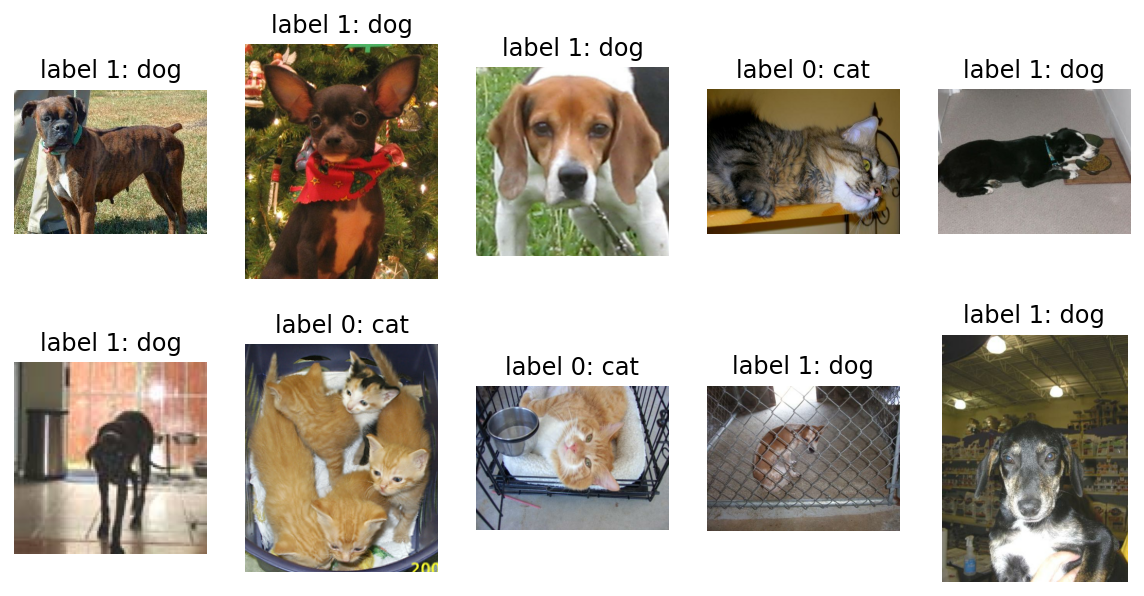

In [25]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [26]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [27]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

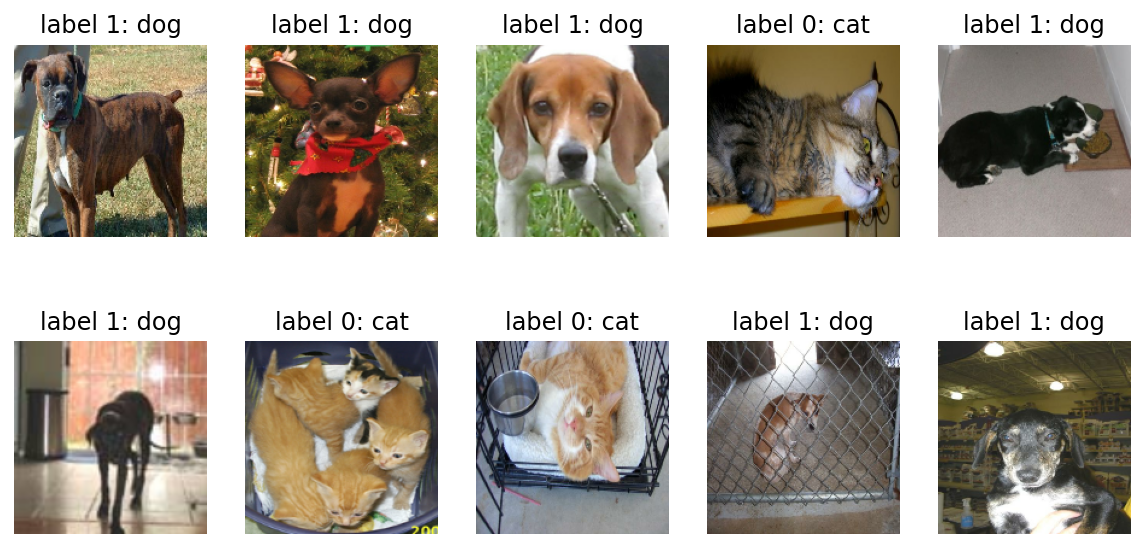

In [28]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [30]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [32]:
import numpy as np

image = np.array([[1, 2], [3, 4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [33]:
image.flatten()

array([1, 2, 3, 4])

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [35]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [36]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [37]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [38]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 88ms/step - loss: 0.6888 - accuracy: 0.5281
initial loss: 0.69
initial accuracy: 0.53


In [39]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 230s 395ms/step - loss: 0.5961 - accuracy: 0.6771 - val_loss: 0.5622 - val_accuracy: 0.7008
Epoch 2/10
582/582 [==============================] - 228s 391ms/step - loss: 0.4858 - accuracy: 0.7696 - val_loss: 0.4852 - val_accuracy: 0.7666
Epoch 3/10
582/582 [==============================] - 226s 388ms/step - loss: 0.4262 - accuracy: 0.8074 - val_loss: 0.4633 - val_accuracy: 0.7893
Epoch 4/10
582/582 [==============================] - 229s 393ms/step - loss: 0.3762 - accuracy: 0.8336 - val_loss: 0.5973 - val_accuracy: 0.7231
Epoch 5/10
582/582 [==============================] - 223s 384ms/step - loss: 0.3300 - accuracy: 0.8578 - val_loss: 0.4901 - val_accuracy: 0.7837
Epoch 6/10
582/582 [==============================] - 219s 377ms/step - loss: 0.2894 - accuracy: 0.8799 - val_loss: 0.4991 - val_accuracy: 0.7803
Epoch 7/10
582/582 [==============================] - 224s 386ms/step - loss: 0.2435 - accuracy: 0.9023 - val_loss: 0.5076 -

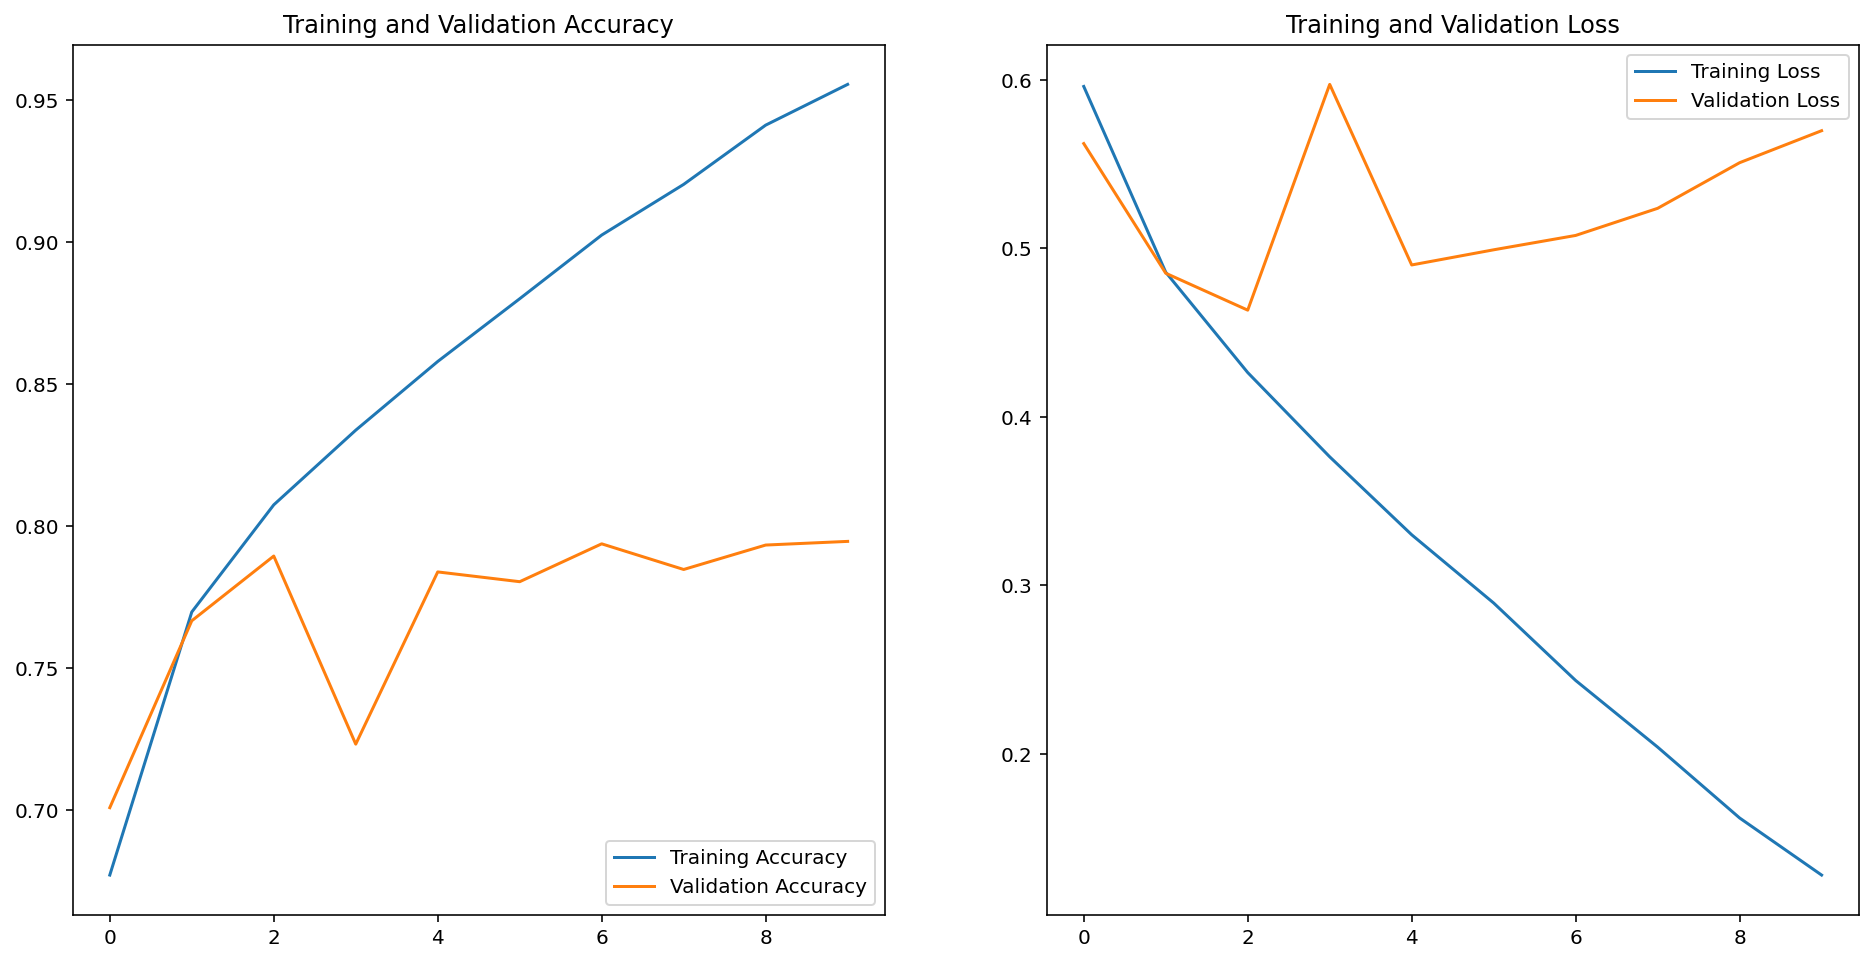

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9996972e-01, 3.0220939e-05],
       [9.6260393e-01, 3.7396032e-02],
       [1.4071985e-01, 8.5928011e-01],
       [9.9998534e-01, 1.4610454e-05],
       [9.8177713e-01, 1.8222908e-02],
       [6.3479894e-01, 3.6520100e-01],
       [3.4866339e-01, 6.5133655e-01],
       [9.7150201e-01, 2.8498003e-02],
       [2.6505572e-01, 7.3494428e-01],
       [6.8101659e-02, 9.3189836e-01],
       [1.0942678e-01, 8.9057320e-01],
       [9.9973792e-01, 2.6210136e-04],
       [9.8957306e-01, 1.0426885e-02],
       [1.1794706e-03, 9.9882048e-01],
       [9.6584618e-01, 3.4153767e-02],
       [9.9847645e-01, 1.5235964e-03],
       [4.2399764e-01, 5.7600236e-01],
       [2.2718239e-04, 9.9977285e-01],
       [6.9871217e-01, 3.0128786e-01],
       [8.5093307e-01, 1.4906694e-01],
       [9.5115167e-01, 4.8848338e-02],
       [9.9946052e-01, 5.3952442e-04],
       [9.9965131e-01, 3.4874253e-04],
       [9.3518424e-01, 6.4815797e-02],
       [9.8462808e-01, 1.5371922e-02],
       [7.4957049e-01, 2.

In [43]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

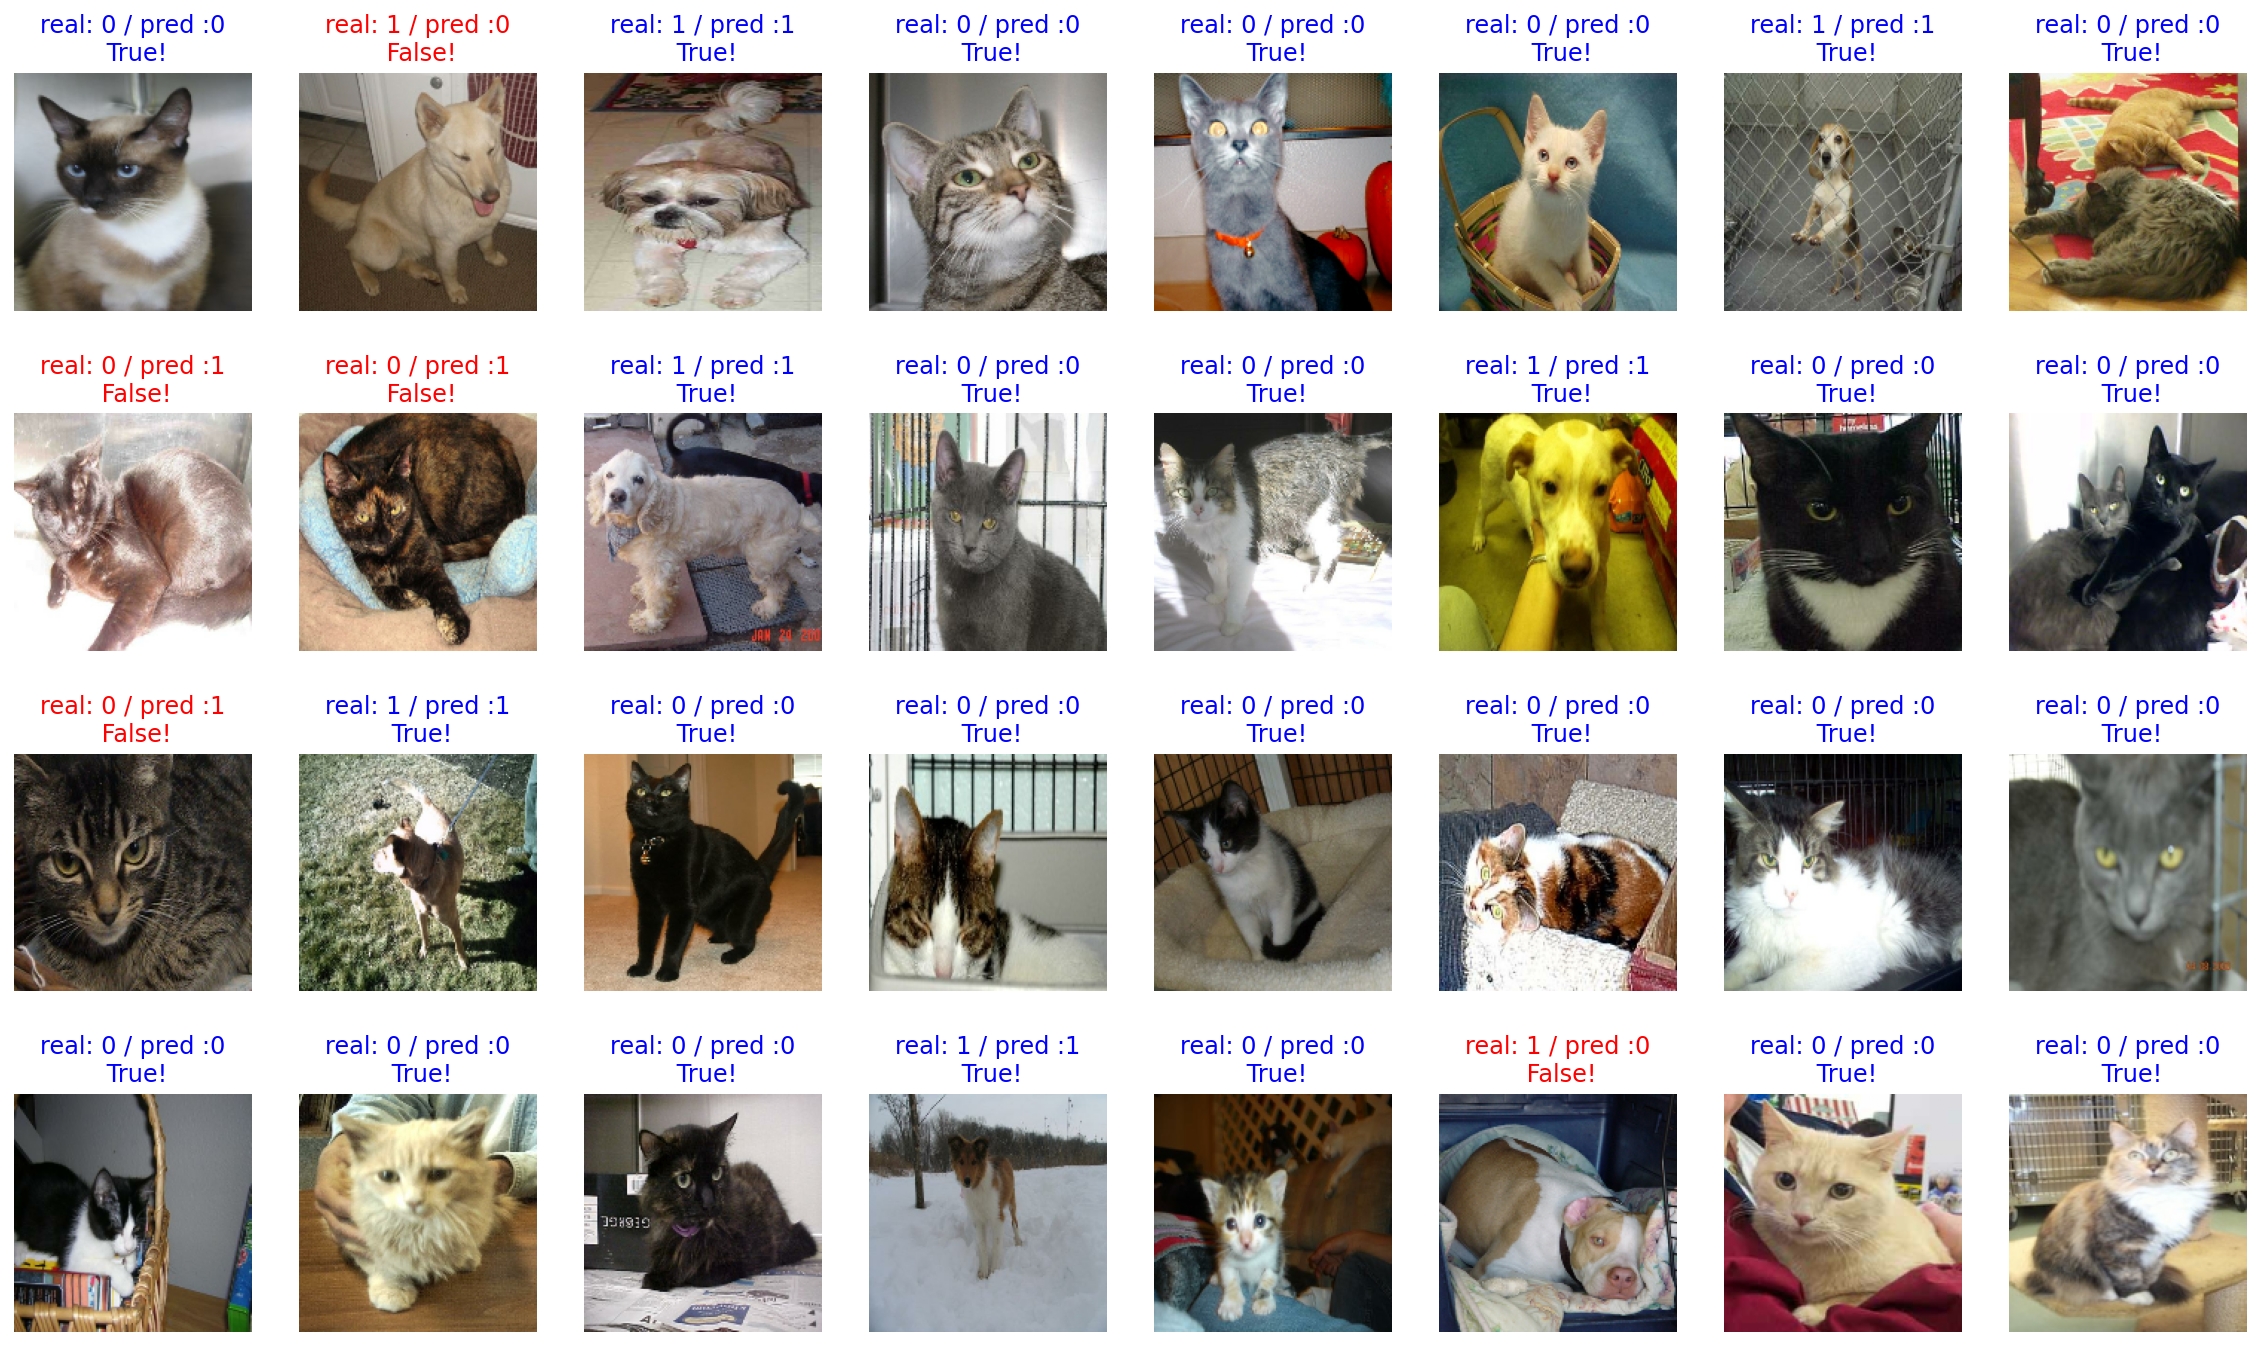

In [44]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [48]:
count = 0   # 정답을 맞춘 개수
i=0
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count = count + 1


print(count / 32 * 100)    # 약 70% 내외

84.375


## 4-9. 내가 직접 만들지 않고 가져다 쓰는 강아지 고양이 분류기 (2) 아주 똑똑한 모델을 간단히 가져오는 방법

사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인하기

그렇다면 이제 설명은 그만, 바로 실행해 보죠!

우리는 2014년의 ILSVRC 물체 위치 찾기(localization) 태스크에서 우승한 VGG 모델을 사용해 보겠습니다.
2014년 이후 뛰어난 성능을 보이는 다양한 새로운 모델이 개발되었지만, VGG는 단순한 구조임에도 꽤나 괜찮은 성능을 보여서 아직까지 많은 이미지 처리 분야에서 사랑받는 모델 중 하나입니다.

다음의 간단한 코드로 VGG 모델을 base_model의 변수로 불러오겠습니다. 이전 스텝에 언급한 대로, VGG 모델을 가져올 때, output에 가까운 높은 레벨에 있는 3개의 FC 레이어는 제외하고 불러와야 하므로 include_top=False 옵션을 주었다는 것을 눈여겨 봐주세요.
텐서플로우 케라스에서 제공하는 VGG16 모델에 대한 상세한 내용은 아래 링크를 참고해 주세요.



In [50]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58892288/58889256 [==============================] - 23s 0us/step


간단하죠? 우리는 방금 이미 잘 학습된 모델을 가져왔습니다.
이 모델은 입력된 이미지를 입력받으면 해당 이미지의 특징을 쏙쏙 잘 뽑아낸 특징 벡터를 추출해낼 수 있죠.

실제로 모델에 이미지 데이터가 들어가면 어떻게 되는지 확인해 보겠습니다. 우리가 학습할 때 사용했던 데이터인 image_batch를 넣어보죠.
넣기 전에 image_batch의 원래 사이즈를 다시 확인해봅시다.



In [51]:
image_batch.shape

TensorShape([32, 160, 160, 3])

위의 shape는 위에서 많이 확인해봤습니다.
다시 한번 짚어보면, 32는 이미지의 장수, 즉 32장의 이미지가 들어있다는 뜻이고, 각 이미지의 크기는 (160, 160, 3)이었습니다.
160은 각각 height와 width, 그리고 3은 채널 수로 R, G, B 3개였죠.

그렇다면 모델에 이 배치를 넣으면 shape가 어떻게 바뀔까요? 확인해봅시다.



In [53]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

어떤가요? 이미지의 개수는 32장으로 여전히 같은데, 이미지의 사이즈가 많이 달라졌습니다.
height와 width는 각각 5로 매우 작아졌고, 512로 channel이 늘어났군요.

이 벡터는 이미지에서 특징을 추출해 낸 "특징 벡터"라고 부르기도 합니다.

그렇다면 모델 구조는 어떤지 살펴볼까요?

In [54]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [ ]:
feature_batch.shape

In [ ]:
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print() * 10
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [ ]:
model.summary()

In [ ]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass
​
predictions

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    #print(image)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

$ mkdir -p ~/aiffel/cat_vs_dog
$ mkdir -p ~/aiffel/cat_vs_dog/checkpoint
$ mkdir -p ~/aiffel/cat_vs_dog/images


In [ ]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

In [ ]:
img_dir_path = os.getenv("HOME") + "/aiffel/cat_vs_dog/images"
print(img_dir_path)
os.path.exists(img_dir_path)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [ ]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

In [ ]:
prediction = model.predict(dog_image)
prediction

In [1]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

In [ ]:
filename = 'dog.jpeg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'cat.jpeg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = "cat2.jpeg"
show_and_predict_image(img_dir_path, filename)